In [1]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    """
    Plots the training metrics including loss on the left, 
    and other metrics like accuracy, precision, recall, f1, auc on the right.
    
    Args:
    metrics_dict (dict): A dictionary containing metrics with 'loss' as a key and the rest of the metrics like accuracy, precision, recall, f1, auc.
    """
    
    epochs = list(range(1, len(metrics_dict['loss']) + 1))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, metrics_dict['loss'], label='Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Loss and Other Metrics over Epochs')

    # Create a second y-axis for the other metrics
    ax2 = ax1.twinx()  
    ax2.plot(epochs, metrics_dict['accuracy'], label='Accuracy', color='green', linestyle='--')
    ax2.plot(epochs, metrics_dict['precision'], label='Precision', color='orange', linestyle='--')
    ax2.plot(epochs, metrics_dict['recall'], label='Recall', color='red', linestyle='--')
    ax2.plot(epochs, metrics_dict['f1_score'], label='F1 Score', color='purple', linestyle='--')
    ax2.plot(epochs, metrics_dict['auc'], label='AUC', color='brown', linestyle='--')

    ax2.set_ylabel('Metrics', color='black')
    ax2.tick_params(axis='y')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.sparse
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch_geometric.data import Data
from torch.optim import Adam
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

# 1. Transform Y for Binary Classification
def transform_y_for_binary_classification(Y):
    # If Y is a numpy array, convert it to a PyTorch tensor
    if isinstance(Y, np.ndarray):
        Y = torch.tensor(Y, dtype=torch.float)
    
        # Convert to binary: 0 if LoS < 7, 1 if LoS >= 7
    return (Y >= 7).float()

class WeightedSumLayer(torch.nn.Module):
    def __init__(self, num_matrices):
        super(WeightedSumLayer, self).__init__()
        self.weights = torch.nn.Parameter(torch.randn(num_matrices))  # Learnable weights

    def forward(self, adjacency_matrices):
        weighted_sum = sum(w * A for w, A in zip(self.weights, adjacency_matrices))
        return weighted_sum

class SAGE_BinaryClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels=16, num_matrices=2):
        super(SAGE_BinaryClassifier, self).__init__()
        self.weighted_sum = WeightedSumLayer(num_matrices)
        self.conv1 = SAGEConv(num_features, hidden_channels, aggr="sum")
        self.conv2 = SAGEConv(hidden_channels, 1, aggr="sum")

    def forward(self, data):
        edge_weight_meta = self.weighted_sum(data.As)
        mask = edge_weight_meta != 0
        edge_index = data.edge_index[:, mask]
        edge_weight_meta = edge_weight_meta[mask]
        x = self.conv1(data.x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def load_dict_from_pickle(filename):
    with open(filename, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

# 2. Modify Evaluation for Binary Classification
def evaluate_binary(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)[mask]
        preds = torch.sigmoid(logits).cpu().numpy()
        binary_preds = (preds > 0.5).astype(int)
        true_labels = data.y[mask].cpu().numpy()

        accuracy = accuracy_score(true_labels, binary_preds)
        precision = precision_score(true_labels, binary_preds)
        recall = recall_score(true_labels, binary_preds)
        f1 = f1_score(true_labels, binary_preds)
        auc = roc_auc_score(true_labels, preds)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc
        }

def load_data(file_path, device, with_SNF, super_class, num_D, num_Meta_Path=5):
    # Load data, assuming the paths are correct
    Y = torch.load(f'{file_path}/Y.pt')
    X = torch.load(f'{file_path}/X.pt')

    if isinstance(X, scipy.sparse.csr_matrix) or isinstance(X, scipy.sparse.csr_array):
        X = torch.tensor(X.toarray(), dtype=torch.float).to(device)  # Convert sparse matrix to dense and then to tensor
    else:
        X = X.to(device)
    
    # Convert LoS into binary classification target
    Y = transform_y_for_binary_classification(Y)  # Transform Y

    # reading patient information...
    Nodes = load_dict_from_pickle(f'{file_path}/Nodes.pkl')
    patient_indices = [i for i, node in enumerate(Nodes) if node[0] == 'C']  # Identify patient nodes
    total_nodes = len(Nodes)

    e = load_dict_from_pickle(f'{file_path}/edges/edge_list.pkl')
    sources, targets = zip(*e)

    edge_index = torch.tensor([sources, targets], dtype=torch.long).to(device)
    edge_weight = [torch.tensor(load_dict_from_pickle(f'{file_path}/edges/edge_weight{i}.pkl')).to(device) for i in range(num_Meta_Path)]

    return X, Y, edge_index, edge_weight, patient_indices, total_nodes

def prepare_masks(Nodes_Path):
    from sklearn.model_selection import train_test_split
    import torch
    
    # Reading the Nodes and all other splits...
    Nodes = load_dict_from_pickle(f'{Nodes_Path}/Nodes.pkl')
    total_nodes = len(Nodes)
    
    # Initialize masks for all nodes
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    test_mask = torch.zeros(total_nodes, dtype=torch.bool)

    # Create a dictionary to map node names to indices
    Nodes_indices = {p: i for i, p in enumerate(Nodes)}
    
    # Split the indices for the nodes with prefix 'V' (patient nodes)
    V_indices = [Nodes_indices[v] for v in Nodes if v[0] == 'V']  # Adjust 'V' if needed for your dataset
    train_indices, temp_indices = train_test_split(V_indices, test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
    
    # Set the appropriate masks
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    return train_mask, val_mask, test_mask


def train(model, data, train_mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data).squeeze(1)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def init_weights(m):
    if isinstance(m, SAGEConv):
        for param in m.parameters():
            if param.requires_grad:
                if param.dim() >= 2:  # Weights (for layers that need them)
                    torch.nn.init.kaiming_uniform_(param, nonlinearity='relu')
                else:  # Bias or 1D parameters
                    torch.nn.init.zeros_(param)

def main(file_path, 
         GNN_Model, 
         num_epochs, 
         with_SNF=False, 
         lr=1e-5, 
         exp_name='emb_result',
         super_class='', 
         num_Meta_Path=5, 
         num_D=10):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X, Y, edge_index, edge_weight, _, total_nodes = load_data(file_path, device, with_SNF, super_class, num_Meta_Path=num_Meta_Path, num_D=num_D)

    data = Data(x=X, y=Y, edge_index=edge_index, As=edge_weight)

    train_mask, val_mask, test_mask = prepare_masks(file_path)
    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)
    data.test_mask = test_mask.to(device)

    num_features = X.size(1)
    model = GNN_Model(num_features, hidden_channels=203, num_matrices=len(data.As)).to(device)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=5e-4, momentum=0.9)
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss

    print(f"Class distribution: {torch.sum(data.y == 0)}, {torch.sum(data.y == 1)}")
    
    # Apply initialization
    model.apply(init_weights)

    metrics_dict = {'loss': [],'accuracy': [],'precision': [],'recall': [],'f1_score': [],'auc': []}
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data).squeeze(1)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        val_metrics = evaluate_binary(model, data, val_mask)
        # Save the metrics for this epoch
        metrics_dict['loss'].append(loss.item())
        metrics_dict['accuracy'].append(val_metrics['accuracy'])
        metrics_dict['precision'].append(val_metrics['precision'])
        metrics_dict['recall'].append(val_metrics['recall'])
        metrics_dict['f1_score'].append(val_metrics['f1_score'])
        metrics_dict['auc'].append(val_metrics['auc'])
        
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {val_metrics["accuracy"]:.4f}, Precision: {val_metrics["precision"]:.4f}, Recall: {val_metrics["recall"]:.4f}, F1: {val_metrics["f1_score"]:.4f}, AUC: {val_metrics["auc"]:.4f}')

    test_metrics = evaluate_binary(model, data, test_mask)
    print(json.dumps(test_metrics, indent=4))
    
    plot_metrics(metrics_dict)

/tmp/ipykernel_786616/2180624707.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(f'{file_path}/Y.pt')
/tmp/ipykernel_786616/2180624707.py:104: FutureWar

Class distribution: 20197, 11672
Epoch 1/15, Loss: 28.0519, Accuracy: 0.5487, Precision: 0.6010, Recall: 0.7363, F1: 0.6618, AUC: 0.5025
Epoch 2/15, Loss: 25.6028, Accuracy: 0.5415, Precision: 0.5977, Recall: 0.7199, F1: 0.6532, AUC: 0.5018
Epoch 3/15, Loss: 21.6560, Accuracy: 0.5379, Precision: 0.5968, Recall: 0.7070, F1: 0.6473, AUC: 0.5031
Epoch 4/15, Loss: 16.6631, Accuracy: 0.5363, Precision: 0.5973, Recall: 0.6959, F1: 0.6429, AUC: 0.5017
Epoch 5/15, Loss: 10.8920, Accuracy: 0.5291, Precision: 0.5959, Recall: 0.6675, F1: 0.6297, AUC: 0.4983
Epoch 6/15, Loss: 4.5682, Accuracy: 0.4359, Precision: 0.5797, Recall: 0.2156, F1: 0.3143, AUC: 0.4951
Epoch 7/15, Loss: 4.5003, Accuracy: 0.4297, Precision: 0.5756, Recall: 0.1864, F1: 0.2816, AUC: 0.4962
Epoch 8/15, Loss: 11.7643, Accuracy: 0.4297, Precision: 0.5752, Recall: 0.1873, F1: 0.2826, AUC: 0.4956
Epoch 9/15, Loss: 16.4893, Accuracy: 0.4333, Precision: 0.5800, Recall: 0.1993, F1: 0.2967, AUC: 0.4946
Epoch 10/15, Loss: 19.0784, Accur

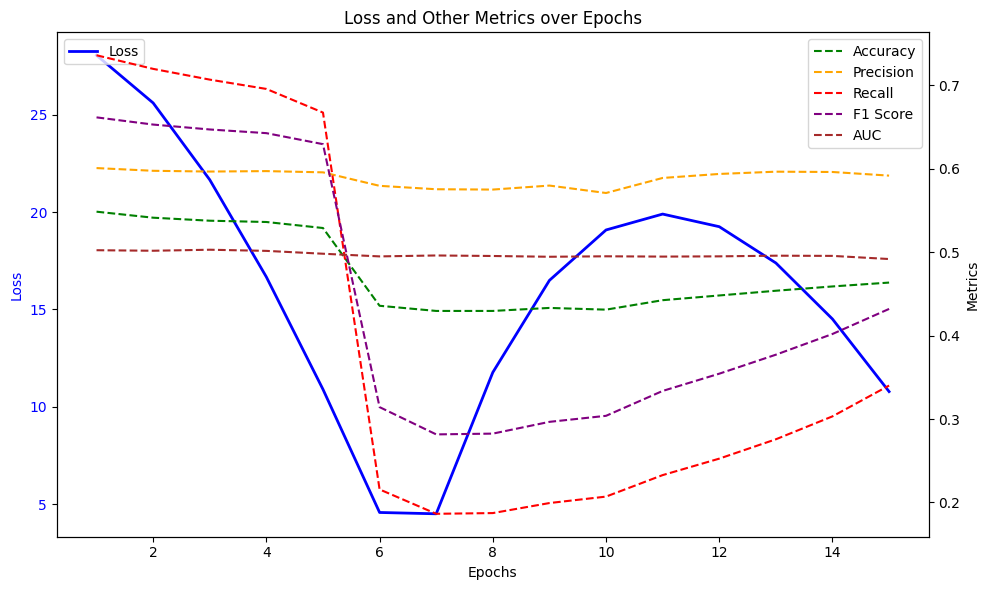

Epoch: 56/250, Loss: 0.6132, Val Precision: 0.0645, ACC: 0.0003, top_k: 0.0937, top_k=1: 0.0937


Epoch: 57/250, Loss: 0.6126, Val Precision: 0.0648, ACC: 0.0004, top_k: 0.0945, top_k=1: 0.0945


Epoch: 58/250, Loss: 0.6121, Val Precision: 0.0651, ACC: 0.0004, top_k: 0.0951, top_k=1: 0.0951


Epoch: 59/250, Loss: 0.6115, Val Precision: 0.0655, ACC: 0.0004, top_k: 0.0960, top_k=1: 0.0960


Epoch: 60/250, Loss: 0.6109, Val Precision: 0.0658, ACC: 0.0004, top_k: 0.0968, top_k=1: 0.0968


Epoch: 61/250, Loss: 0.6104, Val Precision: 0.0658, ACC: 0.0004, top_k: 0.0974, top_k=1: 0.0974


Epoch: 62/250, Loss: 0.6099, Val Precision: 0.0663, ACC: 0.0005, top_k: 0.0981, top_k=1: 0.0981


Epoch: 63/250, Loss: 0.6093, Val Precision: 0.0661, ACC: 0.0005, top_k: 0.0984, top_k=1: 0.0984


Epoch: 64/250, Loss: 0.6088, Val Precision: 0.0664, ACC: 0.0005, top_k: 0.0990, top_k=1: 0.0990


Epoch: 65/250, Loss: 0.6083, Val Precision: 0.0666, ACC: 0.0005, top_k: 0.0995, top_k=1: 0.0995


Epoch: 66/250, Loss: 0.6078, Val Precision: 0.0665, ACC: 0.0005, top_k: 0.1001, top_k=1: 0.1001


Epoch: 67/250, Loss: 0.6073, Val Precision: 0.0671, ACC: 0.0006, top_k: 0.1007, top_k=1: 0.1007


Epoch: 68/250, Loss: 0.6068, Val Precision: 0.0671, ACC: 0.0006, top_k: 0.1011, top_k=1: 0.1011


Epoch: 69/250, Loss: 0.6063, Val Precision: 0.0674, ACC: 0.0007, top_k: 0.1018, top_k=1: 0.1018


Epoch: 70/250, Loss: 0.6059, Val Precision: 0.0659, ACC: 0.0007, top_k: 0.1020, top_k=1: 0.1020


Epoch: 71/250, Loss: 0.6054, Val Precision: 0.0654, ACC: 0.0007, top_k: 0.1024, top_k=1: 0.1024


Epoch: 72/250, Loss: 0.6049, Val Precision: 0.0658, ACC: 0.0008, top_k: 0.1028, top_k=1: 0.1028


Epoch: 73/250, Loss: 0.6045, Val Precision: 0.0665, ACC: 0.0008, top_k: 0.1035, top_k=1: 0.1035


Epoch: 74/250, Loss: 0.6040, Val Precision: 0.0671, ACC: 0.0008, top_k: 0.1039, top_k=1: 0.1039


Epoch: 75/250, Loss: 0.6036, Val Precision: 0.0672, ACC: 0.0010, top_k: 0.1043, top_k=1: 0.1043


Epoch: 76/250, Loss: 0.6031, Val Precision: 0.0670, ACC: 0.0010, top_k: 0.1049, top_k=1: 0.1049


Epoch: 77/250, Loss: 0.6027, Val Precision: 0.0679, ACC: 0.0011, top_k: 0.1056, top_k=1: 0.1056


Epoch: 78/250, Loss: 0.6023, Val Precision: 0.0683, ACC: 0.0011, top_k: 0.1061, top_k=1: 0.1061


Epoch: 79/250, Loss: 0.6018, Val Precision: 0.0667, ACC: 0.0012, top_k: 0.1068, top_k=1: 0.1068


Epoch: 80/250, Loss: 0.6014, Val Precision: 0.0673, ACC: 0.0012, top_k: 0.1074, top_k=1: 0.1074


Epoch: 81/250, Loss: 0.6010, Val Precision: 0.0678, ACC: 0.0012, top_k: 0.1077, top_k=1: 0.1077


Epoch: 82/250, Loss: 0.6005, Val Precision: 0.0667, ACC: 0.0013, top_k: 0.1080, top_k=1: 0.1080


Epoch: 83/250, Loss: 0.6001, Val Precision: 0.0675, ACC: 0.0013, top_k: 0.1087, top_k=1: 0.1087


Epoch: 84/250, Loss: 0.5997, Val Precision: 0.0678, ACC: 0.0013, top_k: 0.1092, top_k=1: 0.1092


Epoch: 85/250, Loss: 0.5993, Val Precision: 0.0676, ACC: 0.0014, top_k: 0.1095, top_k=1: 0.1095


Epoch: 86/250, Loss: 0.5989, Val Precision: 0.0681, ACC: 0.0016, top_k: 0.1101, top_k=1: 0.1101


Epoch: 87/250, Loss: 0.5985, Val Precision: 0.0651, ACC: 0.0015, top_k: 0.1105, top_k=1: 0.1105


Epoch: 88/250, Loss: 0.5981, Val Precision: 0.0657, ACC: 0.0016, top_k: 0.1108, top_k=1: 0.1108


Epoch: 89/250, Loss: 0.5977, Val Precision: 0.0661, ACC: 0.0016, top_k: 0.1114, top_k=1: 0.1114


Epoch: 90/250, Loss: 0.5973, Val Precision: 0.0648, ACC: 0.0017, top_k: 0.1119, top_k=1: 0.1119


Epoch: 91/250, Loss: 0.5969, Val Precision: 0.0646, ACC: 0.0017, top_k: 0.1124, top_k=1: 0.1124


Epoch: 92/250, Loss: 0.5965, Val Precision: 0.0663, ACC: 0.0017, top_k: 0.1141, top_k=1: 0.1141


Epoch: 93/250, Loss: 0.5961, Val Precision: 0.0666, ACC: 0.0017, top_k: 0.1145, top_k=1: 0.1145


Epoch: 94/250, Loss: 0.5957, Val Precision: 0.0677, ACC: 0.0018, top_k: 0.1149, top_k=1: 0.1149


Epoch: 95/250, Loss: 0.5953, Val Precision: 0.0670, ACC: 0.0018, top_k: 0.1156, top_k=1: 0.1156


Epoch: 96/250, Loss: 0.5949, Val Precision: 0.0679, ACC: 0.0018, top_k: 0.1162, top_k=1: 0.1162


Epoch: 97/250, Loss: 0.5946, Val Precision: 0.0686, ACC: 0.0018, top_k: 0.1168, top_k=1: 0.1168


Epoch: 98/250, Loss: 0.5942, Val Precision: 0.0665, ACC: 0.0018, top_k: 0.1173, top_k=1: 0.1173


Epoch: 99/250, Loss: 0.5938, Val Precision: 0.0678, ACC: 0.0018, top_k: 0.1176, top_k=1: 0.1176


Epoch: 100/250, Loss: 0.5934, Val Precision: 0.0686, ACC: 0.0019, top_k: 0.1184, top_k=1: 0.1184


Epoch: 101/250, Loss: 0.5931, Val Precision: 0.0709, ACC: 0.0019, top_k: 0.1189, top_k=1: 0.1189


Epoch: 102/250, Loss: 0.5927, Val Precision: 0.0701, ACC: 0.0019, top_k: 0.1194, top_k=1: 0.1194


Epoch: 103/250, Loss: 0.5923, Val Precision: 0.0699, ACC: 0.0020, top_k: 0.1200, top_k=1: 0.1200


Epoch: 104/250, Loss: 0.5920, Val Precision: 0.0710, ACC: 0.0020, top_k: 0.1204, top_k=1: 0.1204


Epoch: 105/250, Loss: 0.5916, Val Precision: 0.0709, ACC: 0.0021, top_k: 0.1207, top_k=1: 0.1207


Epoch: 106/250, Loss: 0.5912, Val Precision: 0.0693, ACC: 0.0021, top_k: 0.1211, top_k=1: 0.1211


Epoch: 107/250, Loss: 0.5909, Val Precision: 0.0709, ACC: 0.0022, top_k: 0.1215, top_k=1: 0.1215


Epoch: 108/250, Loss: 0.5905, Val Precision: 0.0714, ACC: 0.0022, top_k: 0.1219, top_k=1: 0.1219


Epoch: 109/250, Loss: 0.5902, Val Precision: 0.0721, ACC: 0.0022, top_k: 0.1224, top_k=1: 0.1224


Epoch: 110/250, Loss: 0.5898, Val Precision: 0.0763, ACC: 0.0023, top_k: 0.1229, top_k=1: 0.1229


Epoch: 111/250, Loss: 0.5895, Val Precision: 0.0773, ACC: 0.0023, top_k: 0.1235, top_k=1: 0.1235


Epoch: 112/250, Loss: 0.5891, Val Precision: 0.0771, ACC: 0.0023, top_k: 0.1239, top_k=1: 0.1239


Epoch: 113/250, Loss: 0.5888, Val Precision: 0.0639, ACC: 0.0024, top_k: 0.1241, top_k=1: 0.1241


Epoch: 114/250, Loss: 0.5884, Val Precision: 0.0609, ACC: 0.0024, top_k: 0.1245, top_k=1: 0.1245


Epoch: 115/250, Loss: 0.5881, Val Precision: 0.0587, ACC: 0.0024, top_k: 0.1250, top_k=1: 0.1250


Epoch: 116/250, Loss: 0.5877, Val Precision: 0.0593, ACC: 0.0024, top_k: 0.1255, top_k=1: 0.1255


Epoch: 117/250, Loss: 0.5874, Val Precision: 0.0593, ACC: 0.0024, top_k: 0.1258, top_k=1: 0.1258


Epoch: 118/250, Loss: 0.5871, Val Precision: 0.0597, ACC: 0.0025, top_k: 0.1263, top_k=1: 0.1263


Epoch: 119/250, Loss: 0.5867, Val Precision: 0.0596, ACC: 0.0025, top_k: 0.1273, top_k=1: 0.1273


Epoch: 120/250, Loss: 0.5864, Val Precision: 0.0594, ACC: 0.0025, top_k: 0.1277, top_k=1: 0.1277


Epoch: 121/250, Loss: 0.5860, Val Precision: 0.0597, ACC: 0.0025, top_k: 0.1282, top_k=1: 0.1282


Epoch: 122/250, Loss: 0.5857, Val Precision: 0.0600, ACC: 0.0025, top_k: 0.1285, top_k=1: 0.1285


Epoch: 123/250, Loss: 0.5854, Val Precision: 0.0605, ACC: 0.0025, top_k: 0.1289, top_k=1: 0.1289


Epoch: 124/250, Loss: 0.5850, Val Precision: 0.0608, ACC: 0.0025, top_k: 0.1292, top_k=1: 0.1292


Epoch: 125/250, Loss: 0.5847, Val Precision: 0.0608, ACC: 0.0025, top_k: 0.1308, top_k=1: 0.1308


Epoch: 126/250, Loss: 0.5844, Val Precision: 0.0618, ACC: 0.0026, top_k: 0.1312, top_k=1: 0.1312


Epoch: 127/250, Loss: 0.5841, Val Precision: 0.0600, ACC: 0.0026, top_k: 0.1315, top_k=1: 0.1315


Epoch: 128/250, Loss: 0.5837, Val Precision: 0.0605, ACC: 0.0028, top_k: 0.1319, top_k=1: 0.1319


Epoch: 129/250, Loss: 0.5834, Val Precision: 0.0618, ACC: 0.0028, top_k: 0.1323, top_k=1: 0.1323


Epoch: 130/250, Loss: 0.5831, Val Precision: 0.0622, ACC: 0.0028, top_k: 0.1326, top_k=1: 0.1326


Epoch: 131/250, Loss: 0.5828, Val Precision: 0.0626, ACC: 0.0029, top_k: 0.1330, top_k=1: 0.1330


Epoch: 132/250, Loss: 0.5824, Val Precision: 0.0625, ACC: 0.0029, top_k: 0.1333, top_k=1: 0.1333


Epoch: 133/250, Loss: 0.5821, Val Precision: 0.0632, ACC: 0.0030, top_k: 0.1337, top_k=1: 0.1337


Epoch: 134/250, Loss: 0.5818, Val Precision: 0.0596, ACC: 0.0031, top_k: 0.1340, top_k=1: 0.1340


Epoch: 135/250, Loss: 0.5815, Val Precision: 0.0621, ACC: 0.0032, top_k: 0.1344, top_k=1: 0.1344


Epoch: 136/250, Loss: 0.5812, Val Precision: 0.0634, ACC: 0.0032, top_k: 0.1349, top_k=1: 0.1349


Epoch: 137/250, Loss: 0.5809, Val Precision: 0.0637, ACC: 0.0033, top_k: 0.1375, top_k=1: 0.1375


Epoch: 138/250, Loss: 0.5806, Val Precision: 0.0643, ACC: 0.0033, top_k: 0.1378, top_k=1: 0.1378


Epoch: 139/250, Loss: 0.5802, Val Precision: 0.0631, ACC: 0.0033, top_k: 0.1381, top_k=1: 0.1381


Epoch: 140/250, Loss: 0.5799, Val Precision: 0.0630, ACC: 0.0033, top_k: 0.1383, top_k=1: 0.1383


Epoch: 141/250, Loss: 0.5796, Val Precision: 0.0633, ACC: 0.0034, top_k: 0.1387, top_k=1: 0.1387


Epoch: 142/250, Loss: 0.5793, Val Precision: 0.0634, ACC: 0.0035, top_k: 0.1390, top_k=1: 0.1390


Epoch: 143/250, Loss: 0.5790, Val Precision: 0.0636, ACC: 0.0035, top_k: 0.1392, top_k=1: 0.1392


Epoch: 144/250, Loss: 0.5787, Val Precision: 0.0633, ACC: 0.0035, top_k: 0.1396, top_k=1: 0.1396


Epoch: 145/250, Loss: 0.5784, Val Precision: 0.0632, ACC: 0.0037, top_k: 0.1402, top_k=1: 0.1402


Epoch: 146/250, Loss: 0.5781, Val Precision: 0.0634, ACC: 0.0037, top_k: 0.1405, top_k=1: 0.1405


Epoch: 147/250, Loss: 0.5778, Val Precision: 0.0647, ACC: 0.0037, top_k: 0.1407, top_k=1: 0.1407


Epoch: 148/250, Loss: 0.5775, Val Precision: 0.0643, ACC: 0.0037, top_k: 0.1411, top_k=1: 0.1411


Epoch: 149/250, Loss: 0.5772, Val Precision: 0.0639, ACC: 0.0038, top_k: 0.1413, top_k=1: 0.1413


Epoch: 150/250, Loss: 0.5769, Val Precision: 0.0640, ACC: 0.0038, top_k: 0.1415, top_k=1: 0.1415


Epoch: 151/250, Loss: 0.5766, Val Precision: 0.0646, ACC: 0.0038, top_k: 0.1419, top_k=1: 0.1419


Epoch: 152/250, Loss: 0.5763, Val Precision: 0.0652, ACC: 0.0038, top_k: 0.1423, top_k=1: 0.1423


Epoch: 153/250, Loss: 0.5760, Val Precision: 0.0668, ACC: 0.0038, top_k: 0.1425, top_k=1: 0.1425


Epoch: 154/250, Loss: 0.5757, Val Precision: 0.0675, ACC: 0.0040, top_k: 0.1429, top_k=1: 0.1429


Epoch: 155/250, Loss: 0.5754, Val Precision: 0.0660, ACC: 0.0040, top_k: 0.1432, top_k=1: 0.1432


Epoch: 156/250, Loss: 0.5751, Val Precision: 0.0682, ACC: 0.0040, top_k: 0.1436, top_k=1: 0.1436


Epoch: 157/250, Loss: 0.5748, Val Precision: 0.0671, ACC: 0.0040, top_k: 0.1438, top_k=1: 0.1438


Epoch: 158/250, Loss: 0.5745, Val Precision: 0.0674, ACC: 0.0042, top_k: 0.1441, top_k=1: 0.1441


Epoch: 159/250, Loss: 0.5742, Val Precision: 0.0677, ACC: 0.0042, top_k: 0.1443, top_k=1: 0.1443


Epoch: 160/250, Loss: 0.5739, Val Precision: 0.0682, ACC: 0.0042, top_k: 0.1450, top_k=1: 0.1450


Epoch: 161/250, Loss: 0.5736, Val Precision: 0.0684, ACC: 0.0042, top_k: 0.1452, top_k=1: 0.1452


Epoch: 162/250, Loss: 0.5734, Val Precision: 0.0690, ACC: 0.0042, top_k: 0.1454, top_k=1: 0.1454


Epoch: 163/250, Loss: 0.5731, Val Precision: 0.0694, ACC: 0.0042, top_k: 0.1456, top_k=1: 0.1456


Epoch: 164/250, Loss: 0.5728, Val Precision: 0.0692, ACC: 0.0043, top_k: 0.1459, top_k=1: 0.1459


Epoch: 165/250, Loss: 0.5725, Val Precision: 0.0694, ACC: 0.0046, top_k: 0.1461, top_k=1: 0.1461


Epoch: 166/250, Loss: 0.5722, Val Precision: 0.0698, ACC: 0.0047, top_k: 0.1467, top_k=1: 0.1467


Epoch: 167/250, Loss: 0.5719, Val Precision: 0.0698, ACC: 0.0047, top_k: 0.1475, top_k=1: 0.1475


Epoch: 168/250, Loss: 0.5716, Val Precision: 0.0689, ACC: 0.0047, top_k: 0.1477, top_k=1: 0.1477


Epoch: 169/250, Loss: 0.5714, Val Precision: 0.0691, ACC: 0.0047, top_k: 0.1480, top_k=1: 0.1480


Epoch: 170/250, Loss: 0.5711, Val Precision: 0.0695, ACC: 0.0049, top_k: 0.1482, top_k=1: 0.1482


Epoch: 171/250, Loss: 0.5708, Val Precision: 0.0696, ACC: 0.0049, top_k: 0.1486, top_k=1: 0.1486


Epoch: 172/250, Loss: 0.5705, Val Precision: 0.0713, ACC: 0.0049, top_k: 0.1489, top_k=1: 0.1489


Epoch: 173/250, Loss: 0.5702, Val Precision: 0.0720, ACC: 0.0050, top_k: 0.1492, top_k=1: 0.1492


Epoch: 174/250, Loss: 0.5699, Val Precision: 0.0718, ACC: 0.0050, top_k: 0.1494, top_k=1: 0.1494


Epoch: 175/250, Loss: 0.5697, Val Precision: 0.0725, ACC: 0.0050, top_k: 0.1496, top_k=1: 0.1496


Epoch: 176/250, Loss: 0.5694, Val Precision: 0.0715, ACC: 0.0051, top_k: 0.1499, top_k=1: 0.1499


Epoch: 177/250, Loss: 0.5691, Val Precision: 0.0701, ACC: 0.0051, top_k: 0.1502, top_k=1: 0.1502


Epoch: 178/250, Loss: 0.5688, Val Precision: 0.0703, ACC: 0.0051, top_k: 0.1505, top_k=1: 0.1505


Epoch: 179/250, Loss: 0.5686, Val Precision: 0.0705, ACC: 0.0051, top_k: 0.1509, top_k=1: 0.1509


Epoch: 180/250, Loss: 0.5683, Val Precision: 0.0705, ACC: 0.0050, top_k: 0.1512, top_k=1: 0.1512


Epoch: 181/250, Loss: 0.5680, Val Precision: 0.0714, ACC: 0.0051, top_k: 0.1521, top_k=1: 0.1521


Epoch: 182/250, Loss: 0.5677, Val Precision: 0.0715, ACC: 0.0051, top_k: 0.1523, top_k=1: 0.1523


Epoch: 183/250, Loss: 0.5675, Val Precision: 0.0714, ACC: 0.0051, top_k: 0.1525, top_k=1: 0.1525


Epoch: 184/250, Loss: 0.5672, Val Precision: 0.0722, ACC: 0.0051, top_k: 0.1528, top_k=1: 0.1528


Epoch: 185/250, Loss: 0.5669, Val Precision: 0.0725, ACC: 0.0051, top_k: 0.1530, top_k=1: 0.1530


Epoch: 186/250, Loss: 0.5666, Val Precision: 0.0726, ACC: 0.0051, top_k: 0.1533, top_k=1: 0.1533


Epoch: 187/250, Loss: 0.5664, Val Precision: 0.0727, ACC: 0.0051, top_k: 0.1538, top_k=1: 0.1538


Epoch: 188/250, Loss: 0.5661, Val Precision: 0.0741, ACC: 0.0052, top_k: 0.1542, top_k=1: 0.1542


Epoch: 189/250, Loss: 0.5658, Val Precision: 0.0763, ACC: 0.0052, top_k: 0.1544, top_k=1: 0.1544


Epoch: 190/250, Loss: 0.5656, Val Precision: 0.0771, ACC: 0.0052, top_k: 0.1546, top_k=1: 0.1546


Epoch: 191/250, Loss: 0.5653, Val Precision: 0.0777, ACC: 0.0053, top_k: 0.1548, top_k=1: 0.1548


Epoch: 192/250, Loss: 0.5650, Val Precision: 0.0776, ACC: 0.0053, top_k: 0.1550, top_k=1: 0.1550


Epoch: 193/250, Loss: 0.5648, Val Precision: 0.0772, ACC: 0.0055, top_k: 0.1552, top_k=1: 0.1552


Epoch: 194/250, Loss: 0.5645, Val Precision: 0.0789, ACC: 0.0055, top_k: 0.1554, top_k=1: 0.1554


Epoch: 195/250, Loss: 0.5642, Val Precision: 0.0789, ACC: 0.0055, top_k: 0.1555, top_k=1: 0.1555


Epoch: 196/250, Loss: 0.5640, Val Precision: 0.0803, ACC: 0.0056, top_k: 0.1557, top_k=1: 0.1557


Epoch: 197/250, Loss: 0.5637, Val Precision: 0.0806, ACC: 0.0056, top_k: 0.1561, top_k=1: 0.1561


Epoch: 198/250, Loss: 0.5634, Val Precision: 0.0804, ACC: 0.0056, top_k: 0.1564, top_k=1: 0.1564


Epoch: 199/250, Loss: 0.5632, Val Precision: 0.0820, ACC: 0.0058, top_k: 0.1568, top_k=1: 0.1568


Epoch: 200/250, Loss: 0.5629, Val Precision: 0.0831, ACC: 0.0059, top_k: 0.1571, top_k=1: 0.1571


Epoch: 201/250, Loss: 0.5627, Val Precision: 0.0845, ACC: 0.0060, top_k: 0.1573, top_k=1: 0.1573


Epoch: 202/250, Loss: 0.5624, Val Precision: 0.0861, ACC: 0.0060, top_k: 0.1575, top_k=1: 0.1575


Epoch: 203/250, Loss: 0.5621, Val Precision: 0.0860, ACC: 0.0060, top_k: 0.1580, top_k=1: 0.1580


Epoch: 204/250, Loss: 0.5619, Val Precision: 0.0871, ACC: 0.0060, top_k: 0.1583, top_k=1: 0.1583


Epoch: 205/250, Loss: 0.5616, Val Precision: 0.0877, ACC: 0.0060, top_k: 0.1586, top_k=1: 0.1586


Epoch: 206/250, Loss: 0.5614, Val Precision: 0.0884, ACC: 0.0060, top_k: 0.1587, top_k=1: 0.1587


Epoch: 207/250, Loss: 0.5611, Val Precision: 0.0886, ACC: 0.0060, top_k: 0.1590, top_k=1: 0.1590


Epoch: 208/250, Loss: 0.5608, Val Precision: 0.0888, ACC: 0.0060, top_k: 0.1591, top_k=1: 0.1591


Epoch: 209/250, Loss: 0.5606, Val Precision: 0.0875, ACC: 0.0060, top_k: 0.1594, top_k=1: 0.1594


Epoch: 210/250, Loss: 0.5603, Val Precision: 0.0874, ACC: 0.0062, top_k: 0.1597, top_k=1: 0.1597


Epoch: 211/250, Loss: 0.5601, Val Precision: 0.0876, ACC: 0.0062, top_k: 0.1599, top_k=1: 0.1599


Epoch: 212/250, Loss: 0.5598, Val Precision: 0.0873, ACC: 0.0062, top_k: 0.1600, top_k=1: 0.1600


Epoch: 213/250, Loss: 0.5596, Val Precision: 0.0875, ACC: 0.0063, top_k: 0.1603, top_k=1: 0.1603


Epoch: 214/250, Loss: 0.5593, Val Precision: 0.0878, ACC: 0.0063, top_k: 0.1606, top_k=1: 0.1606


Epoch: 215/250, Loss: 0.5591, Val Precision: 0.0896, ACC: 0.0063, top_k: 0.1609, top_k=1: 0.1609


Epoch: 216/250, Loss: 0.5588, Val Precision: 0.0899, ACC: 0.0065, top_k: 0.1609, top_k=1: 0.1609


Epoch: 217/250, Loss: 0.5586, Val Precision: 0.0897, ACC: 0.0065, top_k: 0.1613, top_k=1: 0.1613


Epoch: 218/250, Loss: 0.5583, Val Precision: 0.0895, ACC: 0.0066, top_k: 0.1615, top_k=1: 0.1615


Epoch: 219/250, Loss: 0.5580, Val Precision: 0.0856, ACC: 0.0066, top_k: 0.1617, top_k=1: 0.1617


Epoch: 220/250, Loss: 0.5578, Val Precision: 0.0857, ACC: 0.0066, top_k: 0.1619, top_k=1: 0.1619


Epoch: 221/250, Loss: 0.5575, Val Precision: 0.0847, ACC: 0.0066, top_k: 0.1621, top_k=1: 0.1621


Epoch: 222/250, Loss: 0.5573, Val Precision: 0.0846, ACC: 0.0067, top_k: 0.1622, top_k=1: 0.1622


Epoch: 223/250, Loss: 0.5570, Val Precision: 0.0858, ACC: 0.0067, top_k: 0.1624, top_k=1: 0.1624


Epoch: 224/250, Loss: 0.5568, Val Precision: 0.0866, ACC: 0.0067, top_k: 0.1625, top_k=1: 0.1625


Epoch: 225/250, Loss: 0.5565, Val Precision: 0.0867, ACC: 0.0067, top_k: 0.1627, top_k=1: 0.1627


Epoch: 226/250, Loss: 0.5563, Val Precision: 0.0866, ACC: 0.0068, top_k: 0.1631, top_k=1: 0.1631


Epoch: 227/250, Loss: 0.5561, Val Precision: 0.0837, ACC: 0.0068, top_k: 0.1634, top_k=1: 0.1634


Epoch: 228/250, Loss: 0.5558, Val Precision: 0.0830, ACC: 0.0068, top_k: 0.1636, top_k=1: 0.1636


Epoch: 229/250, Loss: 0.5556, Val Precision: 0.0835, ACC: 0.0068, top_k: 0.1637, top_k=1: 0.1637


Epoch: 230/250, Loss: 0.5553, Val Precision: 0.0837, ACC: 0.0069, top_k: 0.1640, top_k=1: 0.1640


Epoch: 231/250, Loss: 0.5551, Val Precision: 0.0837, ACC: 0.0069, top_k: 0.1641, top_k=1: 0.1641


Epoch: 232/250, Loss: 0.5548, Val Precision: 0.0811, ACC: 0.0069, top_k: 0.1644, top_k=1: 0.1644


Epoch: 233/250, Loss: 0.5546, Val Precision: 0.0813, ACC: 0.0069, top_k: 0.1646, top_k=1: 0.1646


Epoch: 234/250, Loss: 0.5543, Val Precision: 0.0811, ACC: 0.0069, top_k: 0.1650, top_k=1: 0.1650


Epoch: 235/250, Loss: 0.5541, Val Precision: 0.0813, ACC: 0.0069, top_k: 0.1656, top_k=1: 0.1656


Epoch: 236/250, Loss: 0.5538, Val Precision: 0.0795, ACC: 0.0069, top_k: 0.1657, top_k=1: 0.1657


Epoch: 237/250, Loss: 0.5536, Val Precision: 0.0800, ACC: 0.0069, top_k: 0.1660, top_k=1: 0.1660


Epoch: 238/250, Loss: 0.5534, Val Precision: 0.0801, ACC: 0.0069, top_k: 0.1661, top_k=1: 0.1661


Epoch: 239/250, Loss: 0.5531, Val Precision: 0.0803, ACC: 0.0069, top_k: 0.1663, top_k=1: 0.1663


Epoch: 240/250, Loss: 0.5529, Val Precision: 0.0813, ACC: 0.0069, top_k: 0.1664, top_k=1: 0.1664


Epoch: 241/250, Loss: 0.5526, Val Precision: 0.0815, ACC: 0.0069, top_k: 0.1669, top_k=1: 0.1669


Epoch: 242/250, Loss: 0.5524, Val Precision: 0.0817, ACC: 0.0069, top_k: 0.1671, top_k=1: 0.1671


Epoch: 243/250, Loss: 0.5522, Val Precision: 0.0818, ACC: 0.0070, top_k: 0.1673, top_k=1: 0.1673


Epoch: 244/250, Loss: 0.5519, Val Precision: 0.0819, ACC: 0.0070, top_k: 0.1674, top_k=1: 0.1674


Epoch: 245/250, Loss: 0.5517, Val Precision: 0.0868, ACC: 0.0070, top_k: 0.1677, top_k=1: 0.1677


Epoch: 246/250, Loss: 0.5514, Val Precision: 0.0867, ACC: 0.0071, top_k: 0.1679, top_k=1: 0.1679


Epoch: 247/250, Loss: 0.5512, Val Precision: 0.0865, ACC: 0.0071, top_k: 0.1681, top_k=1: 0.1681


Epoch: 248/250, Loss: 0.5510, Val Precision: 0.0847, ACC: 0.0073, top_k: 0.1682, top_k=1: 0.1682


Epoch: 249/250, Loss: 0.5507, Val Precision: 0.0762, ACC: 0.0074, top_k: 0.1684, top_k=1: 0.1684


{
    "accuracy": 0.00798740015749803,
    "micro_precision": 0.2352059925093633,
    "macro_precision": 0.06701223054187494,
    "recall": 0.010166484417998833,
    "f1_score": 0.014236042683885206,
    "auc": 0.48225735006924303,
    "top_k_1": 0.16861291229724884,
    "top_k_pred": 0.16861291229724884
}
	- Extracting and saving embeddings...


              precision    recall  f1-score   support

     Class 0       0.62      0.10      0.18      6072
     Class 1       0.48      0.04      0.07      4703
     Class 2       0.29      0.01      0.01      4059
     Class 3       0.75      0.34      0.47      4053
     Class 4       0.16      0.00      0.01      3706
     Class 5       0.13      0.04      0.06      3570
     Class 6       0.23      0.01      0.01      3274
     Class 7       0.18      0.00      0.01      3180
     Class 8       0.18      0.01      0.01      2983
     Class 9       0.17      0.00      0.01      2641
    Class 10       0.19      0.01      0.02      2380
    Class 11       0.15      0.00      0.01      2175
    Class 12       0.25      0.00      0.00      2184
    Class 13       0.14      0.00      0.01      2046
    Class 14       0.03      0.00      0.00      1835
    Class 15       0.00      0.00      0.00      1674
    Class 16       0.00      0.00      0.00      1598
    Class 17       0.00    

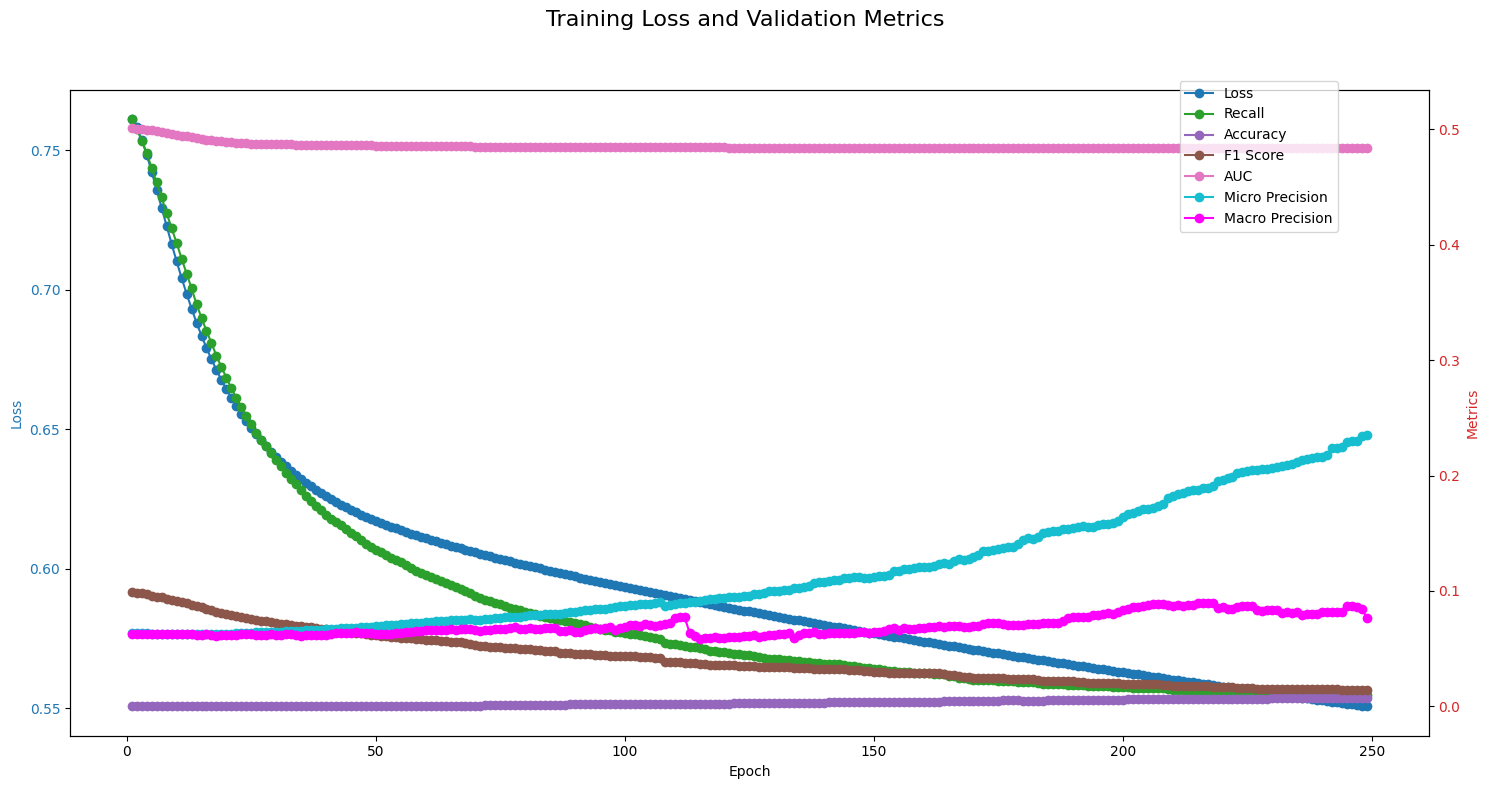

In [3]:
num_Labels = 203
DISEASE_FILE = 'infectious'
# ============================================================================

saving_path = f'../Data/{num_Labels}_Diagnoses/{DISEASE_FILE}'

GNN_model = SAGE_BinaryClassifier
num_epochs = 15
num_Meta_Path = 21
with_SNF = False
super_class = '' # '_sc'

exp_name = f'{num_epochs}_epochs_SNF{super_class}'

losses = main(saving_path, 
               GNN_Model=GNN_model, 
               num_epochs = num_epochs,
               with_SNF = with_SNF,
               exp_name = exp_name,
               super_class = super_class, 
               num_Meta_Path = num_Meta_Path)